## Linear Regression Example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import os
import sys
try:
    # Append PySpark to PYTHONPATH / Spark 2.1.0
    sys.path.append(os.path.join(os.environ["SPARK_HOME"], "python"))
    sys.path.append(os.path.join(os.environ["SPARK_HOME"], "python", "lib",
                                 "py4j-0.10.4-src.zip"))
except KeyError as e:
    print("SPARK_HOME is not set", e)
    sys.exit(1)
    
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.linalg import Vectors

In [2]:
spark_session = SparkSession.builder.getOrCreate()

### Generate Data

In [3]:
# y = b_o + b_1*x + error
# b_0 = 0.5, b_1 = 0.3, error = normally distributed
np.random.seed(1) # set the seed
x = np.arange(100)
error = np.random.normal(0, size=(100,))
y = 0.5 + 0.3 * x + error

In [4]:
sum(x), sum(y) # for testing

(4950, 1541.05828520757)

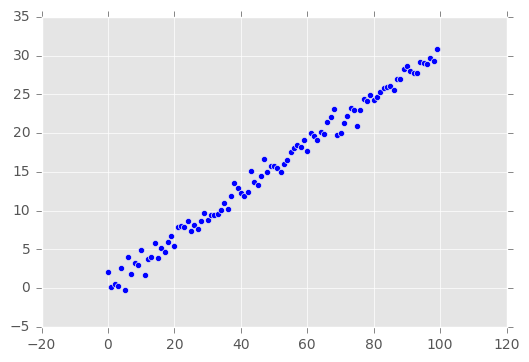

In [5]:
plt.scatter(x, y)
pass

### Convert to Spark DataFrame

In [6]:
data = pd.DataFrame([(i, j) for i, j in zip(x, y)], columns = ["x", "y"])

In [7]:
data_spark = spark_session.createDataFrame(data)

In [8]:
data_spark.show()

+---+-------------------+
|  x|                  y|
+---+-------------------+
|  0| 2.1243453636632417|
|  1|0.18824358634992466|
|  2| 0.5718282477365444|
|  3| 0.3270313778438294|
|  4| 2.5654076293246786|
|  5|-0.3015386968802827|
|  6|   4.04481176421648|
|  7| 1.8387930991048973|
|  8| 3.2190390960570987|
|  9|   2.95062962452259|
| 10| 4.9621079370449745|
| 11| 1.7398592905023458|
| 12|  3.777582795986492|
| 13|  4.015945645331585|
| 14|  5.833769442335438|
| 15|  3.900108732685969|
| 16|  5.127571792449564|
| 17|  4.722141582078628|
| 18|  5.942213746715592|
| 19|  6.782815213715822|
+---+-------------------+
only showing top 20 rows



In [9]:
df = spark_session.createDataFrame((data_spark
 .rdd
 .map(lambda row: (row[1], 0.5, Vectors.dense(row[0]))) 
), ["label", "weight", "features"])

In [10]:
df.columns, df.count() # for testing

(['label', 'weight', 'features'], 100)

### Simple Linear Regression

In [11]:
lr = LinearRegression(maxIter=5, regParam=0.0, solver="normal", weightCol="weight")

In [12]:
model = lr.fit(df)

In [13]:
model.coefficients.values[0] # for testing

0.30334186528098478

In [14]:
model.intercept # for testing

0.3951605206669529

In [15]:
b_0_hat = model.intercept
b_1_hat = model.coefficients.values[0]
y_hat = b_0_hat + b_1_hat * x

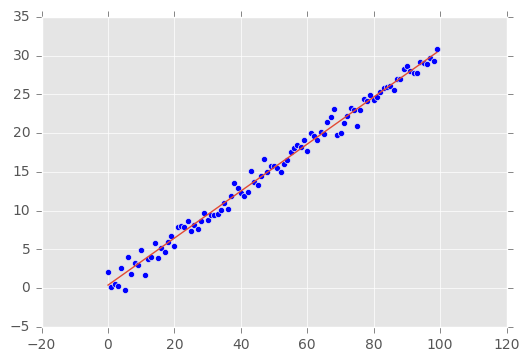

In [16]:
plt.scatter(x, y)
plt.plot(x, y_hat)
pass

In [17]:
model.transform(df).show()

+-------------------+------+--------+------------------+
|              label|weight|features|        prediction|
+-------------------+------+--------+------------------+
| 2.1243453636632417|   0.5|   [0.0]|0.3951605206669529|
|0.18824358634992466|   0.5|   [1.0]|0.6985023859479377|
| 0.5718282477365444|   0.5|   [2.0]|1.0018442512289225|
| 0.3270313778438294|   0.5|   [3.0]|1.3051861165099072|
| 2.5654076293246786|   0.5|   [4.0]| 1.608527981790892|
|-0.3015386968802827|   0.5|   [5.0]|1.9118698470718767|
|   4.04481176421648|   0.5|   [6.0]|2.2152117123528616|
| 1.8387930991048973|   0.5|   [7.0]|2.5185535776338464|
| 3.2190390960570987|   0.5|   [8.0]| 2.821895442914831|
|   2.95062962452259|   0.5|   [9.0]| 3.125237308195816|
| 4.9621079370449745|   0.5|  [10.0]|3.4285791734768005|
| 1.7398592905023458|   0.5|  [11.0]|3.7319210387577852|
|  3.777582795986492|   0.5|  [12.0]|  4.03526290403877|
|  4.015945645331585|   0.5|  [13.0]| 4.338604769319756|
|  5.833769442335438|   0.5|  [

In [18]:
# save model
model.write().overwrite().save("model")

### Predict New Data

In [19]:
model_load = LinearRegressionModel.load("model")

In [20]:
# need the index as dummy column
predict_df = spark_session.createDataFrame([(1, Vectors.dense(0))], ["index", "features"])

In [21]:
model_load.transform(predict_df).show()

+-----+--------+------------------+
|index|features|        prediction|
+-----+--------+------------------+
|    1|   [0.0]|0.3951605206669529|
+-----+--------+------------------+

